# Анализ рыночной корзины (ассоциативные правила)

Данный проект посвящен анализу рыночной корзины с целью выявления закономерностей в покупательском поведении. 
Используя алгоритмы машинного обучения и визуализацию данных, мы исследуем частые наборы товаров и ассоциативные правила.

## Используемые методы и технологии:
- **Предобработка данных**: Очистка данных, удаление некорректных строк, преобразование данных в формат транзакций.
- **Генерация частых наборов (FP-Growth)**: Выявление наиболее часто встречающихся комбинаций товаров с использованием алгоритма FP-Growth.
- **Поиск ассоциативных правил**: Построение правил, описывающих взаимосвязи между товарами, на основе метрик поддержки и уверенности.
- **Визуализация правил (графы)**: Построение интерактивных графов для наглядного представления ассоциативных правил.

## Стек технологий:
- **Pandas**, **NumPy** — обработка и анализ данных.
- **Matplotlib** — построение графиков и визуализация результатов.
- **MLxtend** — реализация алгоритмов FP-Growth и поиска ассоциативных правил.
- **PyVis** — создание интерактивных графов для визуализации взаимосвязей.
- **IPython** — удобное отображение результатов в Jupyter Notebook.


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, fpgrowth
from pyvis.network import Network
from IPython.display import display, HTML, IFrame
simplefilter(action="ignore")

## 1. Предварительная обработка данных
Загрузка данных

In [53]:
dataframe = pd.read_csv("Online Retail.csv")
dataframe.head()


,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Выбор страны из исходных данных для анализа рыночной корзины  
Выберем две страны для последующего сравнения так, чтобы кол-во данных в них было приблизительно одинаковое

In [54]:
a = []
for country in dataframe.Country.unique():
    a.append((len(dataframe[dataframe.Country == country]),country))
a.sort(reverse=True)
b = []
for i in range(1,len(a)):  
    if a[i-1][0] - a[i][0] < a[i][0]/10:
        countries = a[i-1], a[i]
        break 
print(countries)

((8557, 'France'), (8196, 'EIRE'))


In [55]:
first_country = countries[0][1]
second_country = countries[1][1]
code_column =  'Description'
dataset = dataframe[dataframe.Country == first_country].head(len(dataframe[dataframe.Country == second_country]))
dataset[code_column] = dataset[code_column].astype(str)
dataset = dataset[["InvoiceNo","StockCode", 'Description']]
dataset

,InvoiceNo,StockCode,Description
26,536370,22728,ALARM CLOCK BAKELIKE PINK
27,536370,22727,ALARM CLOCK BAKELIKE RED
28,536370,22726,ALARM CLOCK BAKELIKE GREEN
29,536370,21724,PANDA AND BUNNIES STICKER SHEET
30,536370,21883,STARS GIFT TAPE
...,...,...,...
515930,579792,20675,BLUE POLKADOT BOWL
515931,579792,22634,CHILDS BREAKFAST SET SPACEBOY
515932,579792,22635,CHILDS BREAKFAST SET DOLLY GIRL
515933,579792,23256,CHILDRENS CUTLERY SPACEBOY


Удаление строк где нет номеров счетов фактур и строки с кредитными транзакциями XXXXXXXC

In [56]:
# Функция для проверки условий
def custom_filter(stock_code):
    return isinstance(stock_code, int) or any(c.isdigit() for c in stock_code) and not stock_code.endswith('C')

# Применяем функцию к столбцу 'StockCode' для фильтрации
dataset = dataset[dataset["StockCode"].apply(custom_filter)]

dataset = dataset[["InvoiceNo",code_column]]
dataset


,InvoiceNo,Description
26,536370,ALARM CLOCK BAKELIKE PINK
27,536370,ALARM CLOCK BAKELIKE RED
28,536370,ALARM CLOCK BAKELIKE GREEN
29,536370,PANDA AND BUNNIES STICKER SHEET
30,536370,STARS GIFT TAPE
...,...,...
515930,579792,BLUE POLKADOT BOWL
515931,579792,CHILDS BREAKFAST SET SPACEBOY
515932,579792,CHILDS BREAKFAST SET DOLLY GIRL
515933,579792,CHILDRENS CUTLERY SPACEBOY


Представить исходный набор данных в виде множества транзакций

In [57]:
grouped = dataset.groupby("InvoiceNo")[code_column].apply(list)
te = TransactionEncoder()
te_ary = te.fit(grouped).transform(grouped)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TRELLIS COAT RACK,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
0,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
416,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
417,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
418,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## 2. Поиск ассоциативных правил

Генерация частных наборов данных при помощи fp-дерева

In [58]:
min_support = 0.09
frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.161905,(RED TOADSTOOL LED NIGHT LIGHT)
1,0.147619,(ROUND SNACK BOXES SET OF4 WOODLAND )
2,0.114286,(SPACEBOY LUNCH BOX )
3,0.097619,(MINI PAINT SET VINTAGE )
4,0.145238,(LUNCH BAG RED RETROSPOT)
5,0.130952,(LUNCH BOX WITH CUTLERY RETROSPOT )
6,0.126190,(RED RETROSPOT MINI CASES)
7,0.109524,(LUNCH BAG WOODLAND)
8,0.154762,(PLASTERS IN TIN WOODLAND ANIMALS)
9,0.123810,(PLASTERS IN TIN SPACEBOY)


Поиск ассоциативных правил

In [59]:
min_threshold = 0.3
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_threshold)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.123810,0.154762,0.092857,0.750000,4.846154,1.0,0.073696,3.380952,0.905797,0.500000,0.704225,0.675000
1,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.154762,0.123810,0.092857,0.600000,4.846154,1.0,0.073696,2.190476,0.938967,0.500000,0.543478,0.675000
2,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.116667,0.126190,0.111905,0.959184,7.601078,1.0,0.097183,21.408333,0.983139,0.854545,0.953289,0.922988
3,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.126190,0.116667,0.111905,0.886792,7.601078,1.0,0.097183,7.802778,0.993855,0.854545,0.871841,0.922988
4,(SET/6 RED SPOTTY PAPER PLATES),(SET/20 RED RETROSPOT PAPER NAPKINS ),0.116667,0.121429,0.092857,0.795918,6.554622,1.0,0.078690,4.305000,0.959361,0.639344,0.767712,0.780312
5,(SET/20 RED RETROSPOT PAPER NAPKINS ),(SET/6 RED SPOTTY PAPER PLATES),0.121429,0.116667,0.092857,0.764706,6.554622,1.0,0.078690,3.754167,0.964561,0.639344,0.733629,0.780312
6,"(SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...",(SET/6 RED SPOTTY PAPER CUPS),0.092857,0.126190,0.090476,0.974359,7.721335,1.0,0.078759,34.078571,0.959594,0.703704,0.970656,0.845670
7,"(SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...",(SET/20 RED RETROSPOT PAPER NAPKINS ),0.111905,0.121429,0.090476,0.808511,6.658323,1.0,0.076888,4.588095,0.956893,0.633333,0.782045,0.776804
8,"(SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...",(SET/6 RED SPOTTY PAPER PLATES),0.092857,0.116667,0.090476,0.974359,8.351648,1.0,0.079643,34.450000,0.970369,0.760000,0.970972,0.874935
9,(SET/6 RED SPOTTY PAPER PLATES),"(SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...",0.116667,0.092857,0.090476,0.775510,8.351648,1.0,0.079643,4.040909,0.996524,0.760000,0.752531,0.874935


## 3. Исследование  
Исследовать влияние величины пороговых значений для мер
𝑠𝑢𝑝𝑝𝑜𝑟𝑡 и 𝑐𝑜𝑛𝑓𝑖𝑑𝑒𝑛𝑐𝑒 на число генерируемых правил.
Построить соответствующие графики.


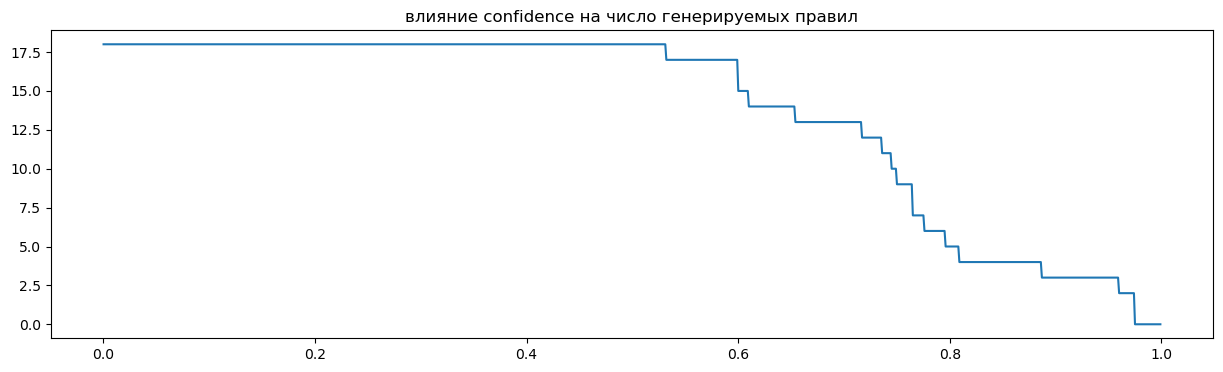

In [60]:
params = np.arange(0.0001,1,0.001)
conf_rules = []
for param in params:
    freq_items = fpgrowth(df, min_support=0.08, use_colnames=True)
    rules_ = association_rules(freq_items, metric="confidence", min_threshold=param)
    conf_rules.append(len(rules_))

plt.figure(figsize=(15,4))
plt.plot(params, conf_rules)
plt.title("влияние confidence на число генерируемых правил")
plt.show()

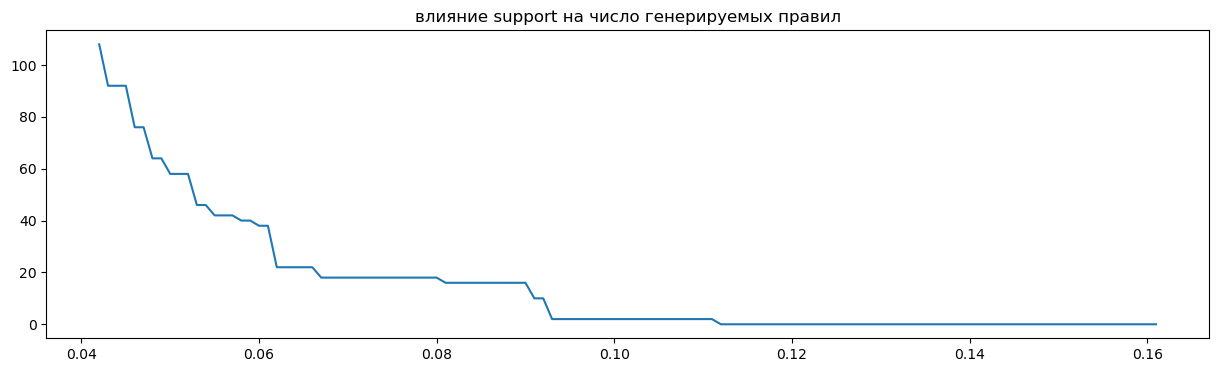

In [61]:
supp_rules = []
params = np.arange(0.042,1,0.001)
for param in params:
    freq_items = fpgrowth(df, min_support=param, use_colnames=True)
    if len(freq_items):
        rules_ = association_rules(freq_items, metric="confidence", min_threshold=0.00001)
        supp_rules.append(len(rules_))
    else:
        params = np.arange(0.042,param-0.001,0.001)
        break
    

plt.figure(figsize=(15,4))
plt.plot(params, supp_rules)
plt.title("влияние support на число генерируемых правил")
plt.show()

## 4. Визуализация полученных правил

In [62]:
def create_graph(rules, name):
    # Получение уникальных элементов из antecedents и consequents
    unique_antecedents = list(set(rules.antecedents.explode()))
    unique_consequents = [x+" " for x in set(rules.consequents.explode())]

    # Создание списка рёбер для графа
    edges = []
    exploded_antecedents = rules.explode("antecedents")
    exploded_consequents = rules.explode("consequents")

    for index, row in exploded_antecedents.iterrows():
        edges.append((row.antecedents, index, f"supp: {row.support}\nconf: {row.confidence}"))

    for index, row in exploded_consequents.iterrows():
        edges.append((index, row.consequents + " ", f"supp: {row.support}\nconf: {row.confidence}"))

    # Инициализация графа
    num_rules = len(list(rules.index))
    net = Network(directed=True)

    # Добавление узлов
    net.add_nodes(unique_antecedents, x= [-500] * len(unique_antecedents), y=[100 * (-len(unique_antecedents) / 2 + i) for i in range(len(unique_antecedents))])
    net.add_nodes(unique_consequents, x= [500] * len(unique_consequents), y= [[100 * (-len(unique_consequents) / 2 + i)] for i in range(len(unique_consequents))])

    net.add_nodes(list(rules.index), label=list(map(str, list(rules.index))), x=[0] * num_rules, y=[[70 * (-num_rules / 2 + i)] for i in range(num_rules)])

    # Добавление рёбер
    for edge in edges:
        net.add_edge(edge[0], edge[1], title=edge[2])

    # Отключение физической симуляции
    net.toggle_physics(False)
    html = net.generate_html()
    with open(f"{name}.html", mode='w', encoding='utf-8') as fp:
            fp.write(html)
    
def show_graph(name):
    # закомментировать при запуске в vs_code
    with open(f"{name}.html", mode='r', encoding='utf-8') as fp:
            html = fp.read()
            
    # display(IFrame(src=f"{name}.html", width=980, height=600))
    # display(HTML(html),display_id="True")

    # раскомментировать при запуске в vs_code
    # net = Network(directed=True)

    # net.show(f"{name}.html", notebook=False)
    
    
    
create_graph(rules, "first")
show_graph("first")


## 5. Сравнение результатов

Подготовим данные по второй стране

In [63]:
dataset = dataframe[dataframe.Country == second_country]
dataset[code_column] = dataset[code_column].astype(str)
dataset = dataset[["InvoiceNo","StockCode", 'Description']]

dataset = dataset[dataset["StockCode"].apply(custom_filter)]
dataset = dataset[["InvoiceNo",code_column]]

grouped = dataset.groupby("InvoiceNo")[code_column].apply(list)
te_ary = te.fit(grouped).transform(grouped)
df = pd.DataFrame(te_ary, columns=te.columns_)

second_frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)

second_rules = association_rules(second_frequent_itemsets, metric="confidence", min_threshold=min_threshold)



Сравним число наборов

In [64]:
print(f"число частых наборов в {first_country} при supp>{min_support}: {len(frequent_itemsets)}")
print(f"число частых наборов в {second_country} при supp>{min_support}: {len(second_frequent_itemsets)}")


число частых наборов в France при supp>0.09: 28
число частых наборов в EIRE при supp>0.09: 13


In [65]:
print(f"Самые частые наборы в {first_country}:")
print(frequent_itemsets.sort_values("support",ascending=False).head(5))

print(f"Самые частые наборы в {second_country}:")
print(second_frequent_itemsets.sort_values("support",ascending=False).head(5))

Самые частые наборы в France:
     support                               itemsets
0   0.161905        (RED TOADSTOOL LED NIGHT LIGHT)
21  0.159524                   (RABBIT NIGHT LIGHT)
8   0.154762     (PLASTERS IN TIN WOODLAND ANIMALS)
17  0.152381       (PLASTERS IN TIN CIRCUS PARADE )
1   0.147619  (ROUND SNACK BOXES SET OF4 WOODLAND )
Самые частые наборы в EIRE:
    support                              itemsets
0  0.309456                            (CARRIAGE)
1  0.217765            (REGENCY CAKESTAND 3 TIER)
2  0.151862    (ROSES REGENCY TEACUP AND SAUCER )
5  0.134670  (WHITE HANGING HEART T-LIGHT HOLDER)
6  0.126074                  (VINTAGE SNAP CARDS)


Cравнение правил

In [66]:
print(f"число правил в {first_country} при conf>{min_threshold}: {len(rules)}")
print(f"число правил в {second_country} при conf>{min_threshold}: {len(second_rules)}")

число правил в France при conf>0.3: 16
число правил в EIRE при conf>0.3: 4


Визуальное сравнение правил

In [67]:
show_graph("first")
create_graph(second_rules, "second")
show_graph("second")
